# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

# 方案1：分步安装
!apt update
!apt install python3-dev build-essential swig cmake python-opengl xvfb -y
!pip install wheel setuptools
!pip install box2d-py --no-cache-dir
!pip install gym==0.21.0
!pip install pyvirtualdisplay tqdm numpy torch

In [62]:
!pip install swig
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay tqdm numpy torch


Next, set up virtual display，and import all necessaary packages.

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [63]:
import random
import numpy as np
import torch

seed = 543 # Do not change this

def fix(env, seed):
    # 兼容新旧版本的方法
    try:
        env.seed(seed)  # 旧版本
    except AttributeError:
        pass  # 新版本没有seed方法

    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [64]:
%%capture
#import gym
import gymnasium as gym
import random
#env = gym.make('LunarLander-v2')
env = gym.make('LunarLander-v3')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [65]:
print(env.observation_space)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [66]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [67]:
initial_state, _ = env.reset()
print(initial_state)

[-0.0046772   1.4117451  -0.47376925  0.03665722  0.00542653  0.10731568
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [68]:
random_action = env.action_space.sample()
print(random_action)

3


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [69]:
print(env.observation_space)
print(env.action_space)

initial_state, _ = env.reset()
print(initial_state)

random_action = env.action_space.sample()
print(random_action)

observation, reward, terminated, truncated, info = env.step(random_action)
done = terminated or truncated

print(done)
print(reward)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Discrete(4)
[-9.28878799e-05  1.40814424e+00 -9.41965543e-03 -1.23365261e-01
  1.14365335e-04  2.13369145e-03  0.00000000e+00  0.00000000e+00]
1
False
-2.6072714931395624


In [70]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [71]:
print(reward)

-2.6072714931395624


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

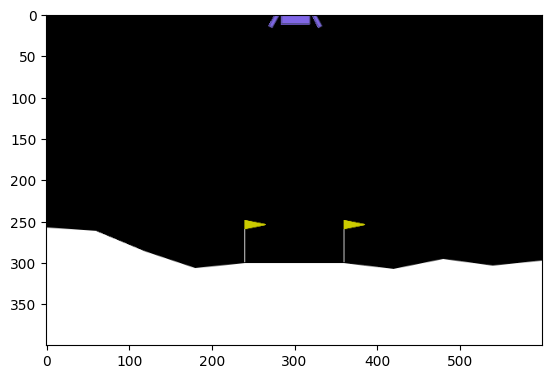

In [72]:
import matplotlib.pyplot as plt
from IPython import display

state, _ = env.reset()

# 创建一个临时的渲染环境
render_env = gym.make('LunarLander-v3', render_mode='rgb_array')
render_env.reset()

img = plt.imshow(render_env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

class ActorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

class CriticNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 输出状态价值
        self.dropout = nn.Dropout(0.2)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [74]:
from torch.optim.lr_scheduler import StepLR
class ActorCriticAgent():
    def __init__(self, actor_network, critic_network):
        self.actor = actor_network
        self.critic = critic_network
        # 分别的优化器
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        # 学习率调度器
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.95)
        self.critic_scheduler = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=100, gamma=0.95)

    def sample(self, state):
        state_tensor = torch.FloatTensor(state)
        action_prob = self.actor(state_tensor)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def learn(self, states, actions, rewards, next_states, dones):
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        rewards = torch.FloatTensor(rewards)
        actions = torch.LongTensor(actions)
        dones = torch.BoolTensor(dones)

        # 计算状态价值
        state_values = self.critic(states).squeeze()
        next_state_values = self.critic(next_states).squeeze()

        # 计算目标价值和优势函数
        gamma = 0.99
        target_values = rewards + gamma * next_state_values * (~dones)
        advantages = target_values - state_values

        # 计算动作概率
        action_probs = self.actor(states)
        action_dist = Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)

        # Actor损失（策略梯度）
        actor_loss = -(log_probs * advantages.detach()).mean()

        # Critic损失（MSE）
        critic_loss = F.mse_loss(state_values, target_values.detach())

        # 更新Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
        self.actor_optimizer.step()

        # 更新Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)
        self.critic_optimizer.step()

        self.actor_scheduler.step()
        self.critic_scheduler.step()

Lastly, build a network and agent to start training.

In [75]:
actor_network = ActorNetwork()
critic_network = CriticNetwork()
agent = ActorCriticAgent(actor_network, critic_network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [76]:
# Actor-Critic训练循环
agent.actor.train()
agent.critic.train()

EPISODE_PER_BATCH = 5
NUM_BATCH = 400

avg_total_rewards, avg_final_rewards = [], []
best_avg_reward = -float('inf')

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    # 初始化batch数据收集
    batch_states, batch_actions, batch_rewards = [], [], []
    batch_next_states, batch_dones = [], []
    total_rewards, final_rewards = [], []

    # 收集一个batch的经验
    for episode in range(EPISODE_PER_BATCH):
        state, _ = env.reset()
        episode_states, episode_actions, episode_rewards = [], [], []
        episode_next_states, episode_dones = [], []
        total_reward = 0

        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            episode_next_states.append(next_state if not done else state)
            episode_dones.append(done)

            state = next_state
            total_reward += reward

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # 将这一episode的数据添加到batch中
        batch_states.extend(episode_states)
        batch_actions.extend(episode_actions)
        batch_rewards.extend(episode_rewards)
        batch_next_states.extend(episode_next_states)
        batch_dones.extend(episode_dones)

    # 更新智能体
    if len(batch_states) > 0:
        agent.learn(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)

    # 记录训练过程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)

    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 只保存最佳模型
    if avg_total_reward > best_avg_reward:
        best_avg_reward = avg_total_reward
        torch.save({
            'actor_state_dict': agent.actor.state_dict(),
            'critic_state_dict': agent.critic.state_dict(),
            'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': agent.critic_optimizer.state_dict(),
            'best_avg_reward': best_avg_reward,
            'batch': batch + 1,
        }, '/content/drive/MyDrive/lunar_lander_ac_best_model.pth')
        print(f"New best AC model saved at batch {batch+1} with avg reward: {best_avg_reward:.2f}")

# 训练完成后保存最终模型
torch.save({
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
    'critic_optimizer_state_dict': agent.critic_optimizer.state_dict(),
    'batch': NUM_BATCH,
    'avg_total_rewards': avg_total_rewards,
    'avg_final_rewards': avg_final_rewards,
    'final_avg_reward': avg_total_rewards[-1] if avg_total_rewards else 0,
}, '/content/drive/MyDrive/lunar_lander_ac_final_model.pth')

print("Actor-Critic training completed!")
print(f"Best average reward achieved: {best_avg_reward:.2f}")

# 保存训练历史
np.save('/content/drive/MyDrive/avg_total_rewards_ac.npy', avg_total_rewards)
np.save('/content/drive/MyDrive/avg_final_rewards_ac.npy', avg_final_rewards)

  0%|          | 0/400 [00:00<?, ?it/s]

/tmp/ipython-input-406423520.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states)


New best AC model saved at batch 1 with avg reward: -204.11
New best AC model saved at batch 2 with avg reward: -119.58
New best AC model saved at batch 9 with avg reward: -83.41
New best AC model saved at batch 11 with avg reward: -77.76
New best AC model saved at batch 53 with avg reward: -29.71
New best AC model saved at batch 156 with avg reward: -11.17
New best AC model saved at batch 214 with avg reward: -3.81
New best AC model saved at batch 312 with avg reward: -0.68
New best AC model saved at batch 322 with avg reward: 6.01
New best AC model saved at batch 323 with avg reward: 93.41
New best AC model saved at batch 400 with avg reward: 146.28
Actor-Critic training completed!
Best average reward achieved: 146.28


### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


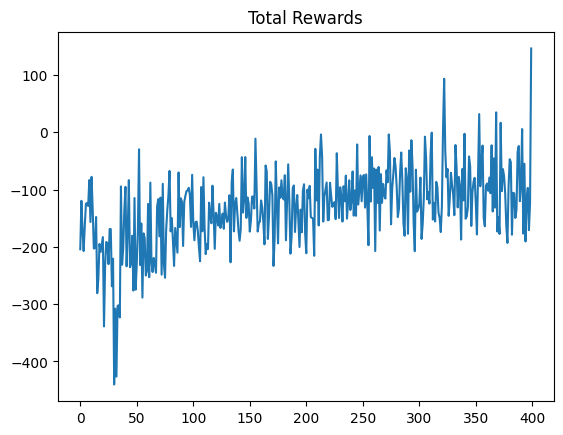

In [77]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


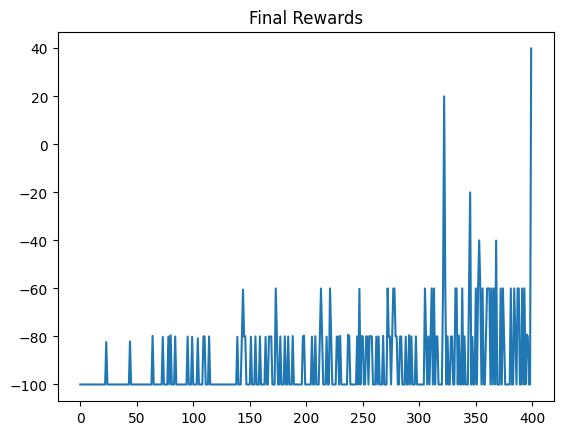

In [78]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
print(np.mean(test_total_reward))

Action list

### This is the file you need to submit !!!
Download the testing result to your device



# Server
The code below simulate the environment on the judge server. Can be used for testing.

# Your score

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
